# Recreate AdeMAMix Rosenbrock Plot from Paper
This notebook attempts to recreate the Figures 2(b) and 2(c) from the [AdeMAMix paper](https://arxiv.org/pdf/2409.03137)

## Imports

In [1]:
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rc('figure', figsize=(20, 10))
plt.rc('font', size=14)

## Functions

In [2]:
def rosenbrock(x):
    return jnp.square(1 - x[0]) + 100. * jnp.square(x[1] - jnp.square(x[0]))

# Create a grid of x and y values
#X, Y = np.meshgrid(np.linspace(-1.3, 1.3, 31), np.linspace(-0.9, 1.7, 31))
x = jnp.linspace(-5, 10, 1000)
y = jnp.linspace(-5, 10, 1000)
X, Y = jnp.meshgrid(x, y)

# Compute the Rosenbrock function values for each point on the grid
Z = rosenbrock([X, Y])

## Generate Adam Trajectories (Baseline)

In [3]:
all_b1_params = []
for b1 in [0.9,0.99,0.999,0.9999]:
    solver = optax.adam(
        learning_rate=0.003,
        b1=b1,
        b2=0.9999,
    )
    params = jnp.array([-3.,5.])
    print("Objective function: ", rosenbrock(params))
    all_params=[params]
    opt_state = solver.init(params)
    for i in range(100000):
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        all_params.append(params)
        # if i%1000 == 0:
        #     print(f"Objective function at iteration {i} = {rosenbrock(params)}")
    all_b1_params.append(all_params)
all_b1_params_array = jnp.array(all_b1_params)

Objective function:  1616.0
Objective function:  1616.0
Objective function:  1616.0
Objective function:  1616.0


## Generate AdeMAMix Trajectories

In [4]:
all_ademamix_params = []
for b3 in [0.999,0.9999]:
    solver = optax.contrib.ademamix(
        learning_rate=0.003,
        b1=.99,
        b2=0.999,
        b3=b3,
    )
    params = jnp.array([-3.,5.])
    print("Objective function: ", rosenbrock(params))
    all_params=[params]
    opt_state = solver.init(params)
    for i in range(100000):
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        all_params.append(params)
        # if i%1000 == 0:
        #     print(f"Objective function at iteration {i} = {rosenbrock(params)}")
    all_ademamix_params.append(all_params)
all_ademamix_params_array = jnp.array(all_ademamix_params)

Objective function:  1616.0
Objective function:  1616.0


## Plot the Figure

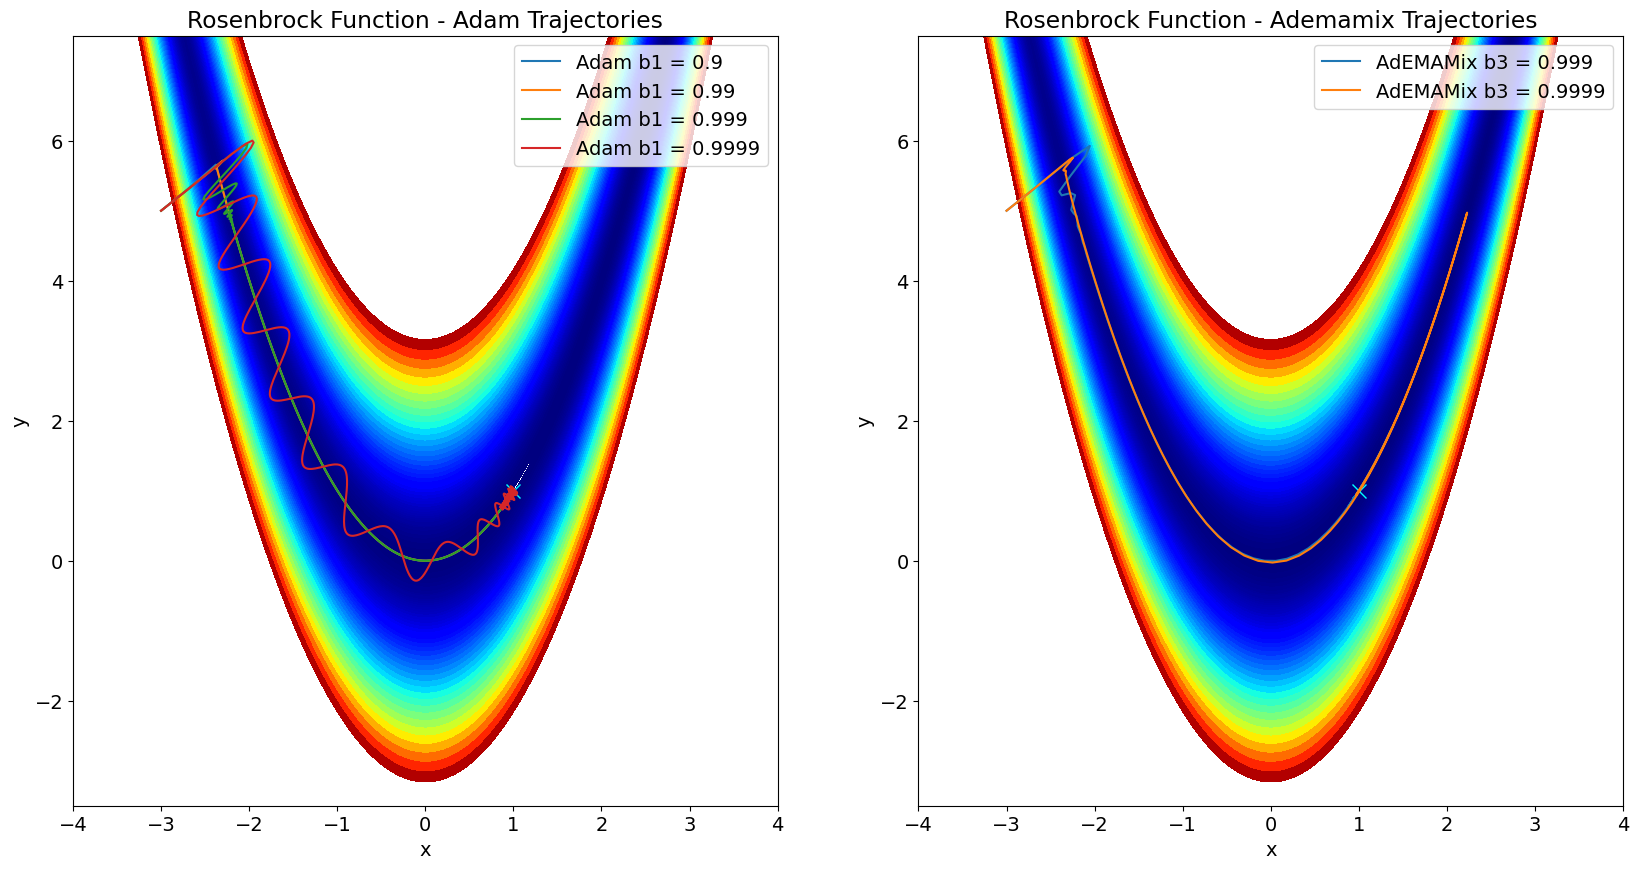

In [12]:
fig = plt.figure()
ax = fig.subplots(1,2)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Rosenbrock Function - Adam Trajectories')
# Show the plot
ax[0].plot([1], [1], 'x', mew=1, markersize=10, color='cyan')
ax[0].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap='jet')
for i, b1 in enumerate([0.9,0.99,0.999,0.9999]):
    ax[0].plot(all_b1_params_array[i,::100,0], all_b1_params_array[i,::100,1],label=f'Adam b1 = {b1}')
ax[0].set_xlim(-4,4)
ax[0].set_ylim(-3.5,7.5)
ax[0].legend()

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Rosenbrock Function - Ademamix Trajectories')
# Show the plot
ax[1].plot([1], [1], 'x', mew=1, markersize=10, color='cyan')
ax[1].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap='jet')
for i, b3 in enumerate([0.999,0.9999]):
    ax[1].plot(all_ademamix_params_array[i,::100,0], all_ademamix_params_array[i,::100,1],label=f'AdEMAMix b3 = {b3}')
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-3.5,7.5)
ax[1].legend()

plt.show()

## Print out final values

In [17]:
print("Adam Values:")
[0.9,0.99,0.999,0.9999]
print(f"Final value with b1 = 0.9: ({float(all_ademamix_params_array[0,-1,0]),float(all_ademamix_params_array[0,-1,1])})")
print(f"Final value with b1 = 0.99: ({float(all_ademamix_params_array[1,-1,0]),float(all_ademamix_params_array[1,-1,1])})")
print(f"Final value with b1 = 0.999: ({float(all_ademamix_params_array[0,-1,0]),float(all_ademamix_params_array[0,-1,1])})")
print(f"Final value with b1 = 0.9999: ({float(all_ademamix_params_array[1,-1,0]),float(all_ademamix_params_array[1,-1,1])})")

print("AdeMAMix Values:")
print(f"Final value with b3 = 0.999: ({float(all_ademamix_params_array[0,-1,0]),float(all_ademamix_params_array[0,-1,1])})")
print(f"Final value with b3 = 0.9999: ({float(all_ademamix_params_array[1,-1,0]),float(all_ademamix_params_array[1,-1,1])})")

AdeMAMix Values:
Final value with b3 = 0.999: ((1.0000168085098267, 0.9999828934669495))
Final value with b3 = 0.9999: ((1.0000070333480835, 0.9999932050704956))


In [13]:
all_b1_params_array.shape

(2, 100001, 2)